In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

In [3]:
def f(x, a, b):
    return a/(1+(x-b)**2)

def mu(x):
    return f(x, 1, 0) + f(x, 2, 3)

def generate_data(n):
    x = np.random.uniform(-5, 5, n)
    y = mu(x) + 0.5*np.random.randn(n)
    return np.column_stack((x, y))

In [4]:
n_train, n_cal, n_test = 1000, 3000, 3000
n = n_train + n_cal + n_test
alpha = 0.1

D = generate_data(n)

D_train = D[:n_train,:]
D_cal = D[n_train:(n_train + n_cal),:]
D_test = D[(n_train + n_cal):(n_train + n_cal + n_test),:]

X_train, Y_train = D_train[:, 0], D_train[:, 1]
X_cal, Y_cal = D_cal[:, 0], D_cal[:, 1]
X_test, Y_test = D_test[:, 0], D_test[:, 1]

In [5]:
def absolute_residual_score(x, y, model):
    return np.abs(y - model.predict(x).flatten())

def locally_weighted_score(x, y, mu_model, sigma_model):
    return np.abs(y - mu_model.predict(x).flatten())/sigma_model.predict(x).flatten()

def quantile_score(x, y, lower_q_model, upper_q_model):
    l = lower_q_model.predict(x) - y
    u = y - upper_q_model.predict(x)
    return np.maximum(l, u)

q_cal = int(np.ceil((1-alpha)*(n_cal + 1)))

In [6]:
# Split CP with linear regression
model = LinearRegression()
model.fit(X_train.reshape(-1, 1), Y_train.reshape(-1, 1))

scores = absolute_residual_score(X_cal.reshape(-1, 1), Y_cal, model)

Y_pred = model.predict(X_test.reshape(-1, 1)).flatten()

q = np.sort(scores.flatten())[q_cal - 1]
y_upper = Y_pred + q
y_lower = Y_pred - q

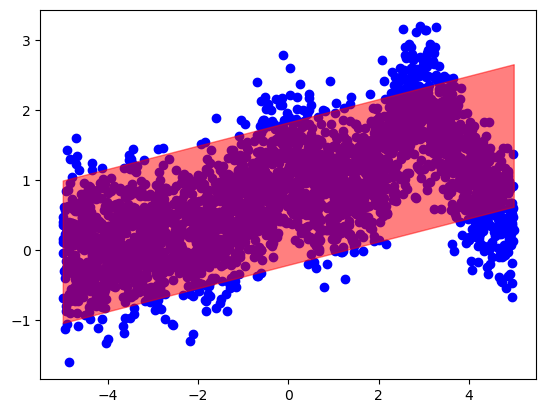

In [7]:
plt.scatter(X_test, Y_test, color="blue")
plt.fill_between(X_test[np.argsort(X_test)], y_lower[np.argsort(X_test)], y_upper[np.argsort(X_test)], color="red", alpha = 0.5)

In [8]:
# Split CP with random forests
n_estimators = [100, 150, 200]
max_depth = [5, 10, 15]
min_samples_split = [2, 6, 10]

param_grid = {"n_estimators": n_estimators,
              "max_depth": max_depth,
              "min_samples_split": min_samples_split}

model_RF = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid= param_grid,
                     cv = 5,
                     n_jobs=4)

model_RF.fit(X_train.reshape(-1, 1), Y_train.reshape(-1, 1))
model_RF.best_params_

c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}

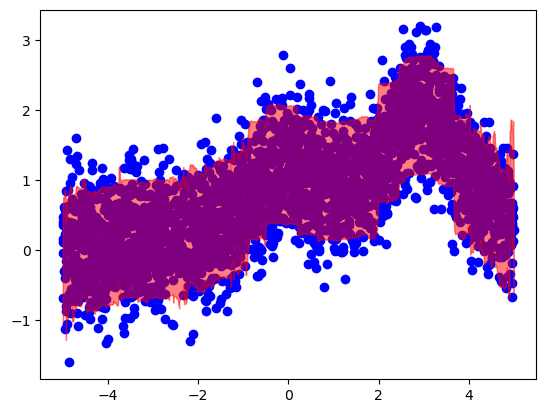

In [9]:
scores_RF = absolute_residual_score(X_cal.reshape(-1, 1), Y_cal, model_RF)

Y_pred_RF = model_RF.predict(X_test.reshape(-1, 1)).flatten()

q_RF = np.sort(scores_RF.flatten())[q_cal - 1]
y_upper_RF = Y_pred_RF + q_RF
y_lower_RF = Y_pred_RF - q_RF

plt.scatter(X_test, Y_test, color="blue")
plt.fill_between(X_test[np.argsort(X_test)], y_lower_RF[np.argsort(X_test)], y_upper_RF[np.argsort(X_test)], color="red", alpha = 0.5)

In [10]:
def check_coverage(alpha, n, y, y_lower, y_upper, q_cal):
    if q_cal >= n+1:
        return 1
    else:
        return np.mean((y <= y_upper) & (y >= y_lower))

In [11]:
print(check_coverage(alpha, n_cal, Y_test, y_lower, y_upper, q_cal))
print(check_coverage(alpha, n_cal, Y_test, y_lower_RF, y_upper_RF, q_cal))

0.889
0.897


In [12]:
print(np.mean(np.abs(y_upper - y_lower)))
print(np.mean(np.abs(y_upper_RF - y_lower_RF)))

2.035929725841875
1.6862041293796934
